In [15]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull, distance
from matplotlib.patches import FancyArrowPatch
import itertools

class Arrow3D(FancyArrowPatch):
    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs) 

def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)

def plot_poly(ax, cube, color, points=False, zorder=0):
    def dist(i, j):
        return distance.euclidean(cube[s[i]], cube[s[j]])

    hull = ConvexHull(cube)
    for i, s in enumerate(hull.simplices):
        if color != 'none':
            tri = Poly3DCollection([cube[s]])
            tri.set_color(color)
            tri.set_alpha(0.5)
            tri.set_edgecolor('none')
            tri.zorder = zorder
            ax.add_collection3d(tri)
        edges = []
        pairs = [ (0, 1), (1, 2), (2, 0) ]
        lengths = [dist(*pa) for pa in pairs ]
        sort = sorted( zip(lengths, pairs), key = lambda x:x[0] )

        if len(set(lengths)) == 1:
            edges += [ (s[p1], s[p2]) for _, (p1, p2) in sort ]
        else:
            edges += [ (s[p1], s[p2]) for _, (p1, p2) in sort[:-1] ]
        
        for v0, v1 in edges:
            ax.plot(xs=cube[[v0, v1], 0], ys=cube[[v0, v1], 1], zs=cube[[v0, v1], 2], color='black')

    if points:
        ax.scatter(cube[:, 0], cube[:, 1], cube[:, 2], marker='o', color='gray')

def plot_lines(ax, arr, roll=[0,1,2], ls='--', lw=1, color='gray', zorder=1):
    for r in roll:
        ax.plot(*np.roll(arr.T, r, axis=0), linestyle=ls, linewidth=lw, color=color, zorder=zorder)


def get_cube_points(ll, ur):
    mat = np.array( list(zip(ll, ur)) )
    xx, yy, zz = np.meshgrid( *mat )
    points = np.array( list(zip(xx.flatten(), yy.flatten(), zz.flatten())) )
    order = [ 0, 1, 2, 3, 4, 5, 6, 7 ]
    return points[order]

def plot_axes(ax, size=3.9, off=[0,0,0]):
    offset = np.array(off*3).reshape((3,3))
    ends = size * np.identity(3) 
    colors = ['red', 'green', 'blue']
    #colors = ['black']*3

    for arr, color in zip(ends, colors):
        ax.arrow3D( *off, *arr, mutation_scale=15, fc=color, ec='black')


lines = np.array(
    [
        [ 0, 2, 2],
        [ 0, 2,-2],
        [ 0,-2,-2],
        [ 0,-2, 2],
        [ 0, 2, 2]
    ]
  )


o1 = get_cube_points([-2, -2, -2], [-1,2,2])
o2 = get_cube_points([1, -2, -2], [2,2,2])
ori = get_cube_points([-2, -2, -2], [2,2,2])

A = get_cube_points( [-1,-2,-2], [1,2,2] )

C = np.array(
    [
        [ 2, 0,-2],
        [ 0, 2,-2],
        [ 0,-2,-2],
        [-2, 0,-2],
        [ 2, 0, 2],
        [ 0, 2, 2],
        [ 0,-2, 2],
        [-2, 0, 2]
    ]
  )

G = np.array(
    [
        [ 2, 0, 0],
        [-2, 0, 0],
        [ 0, 2, 0],
        [ 0,-2, 0],
        [ 0, 0, 2],
        [ 0, 0,-2]
    ]
  )

Gnew = 4*np.array([[ 0.  , -0.5 , -0.25],
       [ 0.  , -0.25, -0.5 ],
       [-0.5 , -0.25,  0.  ],
       [-0.25, -0.5 ,  0.  ],
       [ 0.5 , -0.25,  0.  ],
       [ 0.25, -0.5 ,  0.  ],
       [ 0.  , -0.5 ,  0.25],
       [ 0.  , -0.25,  0.5 ],
       [-0.5 ,  0.  , -0.25],
       [-0.25,  0.  , -0.5 ],
       [ 0.5 ,  0.  , -0.25],
       [ 0.25,  0.  , -0.5 ],
       [ 0.  ,  0.25, -0.5 ],
       [ 0.  ,  0.5 , -0.25],
       [ 0.5 ,  0.  ,  0.25],
       [ 0.25,  0.  ,  0.5 ],
       [ 0.5 ,  0.25,  0.  ],
       [ 0.25,  0.5 ,  0.  ],
       [-0.5 ,  0.  ,  0.25],
       [-0.25,  0.  ,  0.5 ],
       [-0.5 ,  0.25,  0.  ],
       [-0.25,  0.5 ,  0.  ],
       [ 0.  ,  0.25,  0.5 ],
       [ 0.  ,  0.5 ,  0.25]])

path = 4*np.array([
    [0,   0,   0],
    [0.5, 0,   0],
    [0.5, 0.5, 0],
    [0,   0,   0],
    [0.5, 0.5, 0.5]
    ])

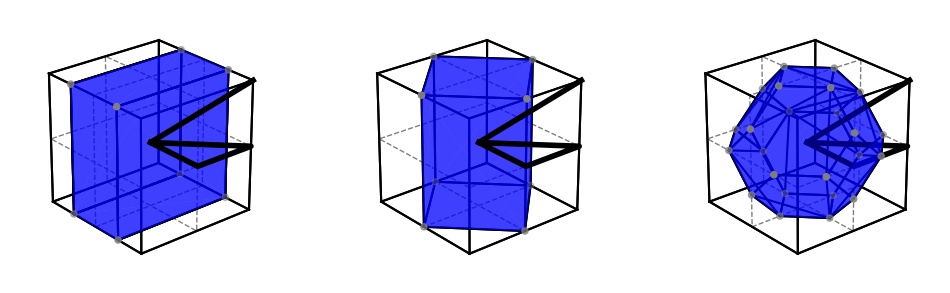

In [28]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(131, projection="3d")
ax2 = fig.add_subplot(132, projection="3d")
ax3 = fig.add_subplot(133, projection="3d")
for ax in [ax1, ax2, ax3]:
    ax.set_box_aspect(aspect = (1,1,1))
    ax.set_axis_off()
    ax.view_init(25, -40)
    #plot_axes(ax, size=1, off=[0, -4.0, -1])

for ax in [ax1, ax2, ax3]:
    plot_lines(ax, path, roll=[0], ls='-', lw=4, color='k', zorder=15)

#A-type
plot_poly(ax1, o1, 'none')
plot_poly(ax1, o2, 'none')
plot_poly(ax1, A, 'blue', points=True)
plot_lines(ax1, lines, roll=[0,1,2])

#C-type
plot_poly(ax2, ori, 'none')
plot_poly(ax2, C, 'blue', points=True)
plot_lines(ax2, lines, roll=[0,1,2])

#G-type
plot_lines(ax3, lines)
plot_poly(ax3, ori, 'none')
plot_poly(ax3, Gnew, 'blue', points=True)

plt.show()